In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_kcat = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/kcat_with_features.joblib')
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,log10kcat_max,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [3]:
data_kcat.rename(columns={'log10kcat_max':'label'},inplace=True)
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,label,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [4]:
data_kcat.shape

(23151, 12)

In [5]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [6]:
# Separate the dataset by unique proteins and drugs
unique_proteins = data_kcat['Sequence'].unique()
unique_mols = data_kcat['Smiles'].unique()
# Set the seed for reproducibility
torch.manual_seed(42)
# Function to perform a cold split
def cold_split(unique_items, test_size=0.2, val_size=0.1):
    train_items, test_items = train_test_split(unique_items, test_size=test_size, random_state=42)
    train_items, val_items = train_test_split(train_items, test_size=val_size / (1 - test_size), random_state=42)
    return train_items, val_items, test_items
# Cold split by proteins
train_proteins, val_proteins, test_proteins = cold_split(unique_proteins)
train_cold_protein = data_kcat[data_kcat['Sequence'].isin(train_proteins)]
val_cold_protein = data_kcat[data_kcat['Sequence'].isin(val_proteins)]
test_cold_protein = data_kcat[data_kcat['Sequence'].isin(test_proteins)]
# Cold split by molecules
train_mols, val_mols, test_mols = cold_split(unique_mols)
train_cold_mols = data_kcat[data_kcat['Smiles'].isin(train_mols)]
val_cold_mols = data_kcat[data_kcat['Smiles'].isin(val_mols)]
test_cold_mols = data_kcat[data_kcat['Smiles'].isin(test_mols)]

In [7]:
# cold protein
'''
train_dataset = MPI_Dataset(train_cold_protein)
val_dataset = MPI_Dataset(val_cold_protein)
test_dataset = MPI_Dataset(test_cold_protein)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

# cold mols

'''
train_dataset = MPI_Dataset(train_cold_mols)
val_dataset = MPI_Dataset(val_cold_mols)
test_dataset = MPI_Dataset(test_cold_mols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

'\ntrain_dataset = MPI_Dataset(train_cold_mols)\nval_dataset = MPI_Dataset(val_cold_mols)\ntest_dataset = MPI_Dataset(test_cold_mols)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n\n'

In [8]:
# Load data_kcat
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_kcat, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define CNN Model for Regression
class CNNRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, out_dim=1):
        super(CNNRegressor, self).__init__()

        self.mol_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.protein_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        with torch.no_grad():
            dummy_mol = torch.zeros(1, 1, mol_input_dim)
            dummy_protein = torch.zeros(1, 1, protein_input_dim)
    
            mol_flatten_len = self.mol_conv(dummy_mol).view(1, -1).size(1)
            protein_flatten_len = self.protein_conv(dummy_protein).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(mol_flatten_len + protein_flatten_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_input = mol_input.unsqueeze(1)
        protein_input = protein_input.unsqueeze(1)

        mol_out = self.mol_conv(mol_input)
        protein_out = self.protein_conv(protein_input)

        # Flatten
        mol_out = mol_out.view(mol_out.size(0), -1)
        protein_out = protein_out.view(protein_out.size(0), -1)

        combined = torch.cat([mol_out, protein_out], dim=1)
        output = self.fc(combined).squeeze()
        return output


In [10]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Training Epoch 1: 100%|██████████| 507/507 [00:36<00:00, 13.92it/s]


Epoch 0 - Train Loss: 2.7202, Train MSE: 2.7214, Train MAE: 1.2642


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_16833/3486802603.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.4747, Validation MSE: 2.4770, Validation MAE: 1.2107


Training Epoch 11: 100%|██████████| 507/507 [00:29<00:00, 17.01it/s]


Epoch 10 - Train Loss: 2.1785, Train MSE: 2.1787, Train MAE: 1.1224
Epoch 10 - Validation Loss: 2.1173, Validation MSE: 2.1177, Validation MAE: 1.1201


Training Epoch 21: 100%|██████████| 507/507 [00:36<00:00, 13.76it/s]


Epoch 20 - Train Loss: 1.9379, Train MSE: 1.9376, Train MAE: 1.0543
Epoch 20 - Validation Loss: 1.9542, Validation MSE: 1.9555, Validation MAE: 1.0721


Training Epoch 31: 100%|██████████| 507/507 [00:26<00:00, 19.23it/s]


Epoch 30 - Train Loss: 1.7498, Train MSE: 1.7496, Train MAE: 1.0006
Epoch 30 - Validation Loss: 1.8760, Validation MSE: 1.8774, Validation MAE: 1.0437


Training Epoch 41: 100%|██████████| 507/507 [00:27<00:00, 18.30it/s]


Epoch 40 - Train Loss: 1.5883, Train MSE: 1.5887, Train MAE: 0.9509
Epoch 40 - Validation Loss: 1.8553, Validation MSE: 1.8575, Validation MAE: 1.0332


Training Epoch 51: 100%|██████████| 507/507 [00:31<00:00, 16.24it/s]


Epoch 50 - Train Loss: 1.4670, Train MSE: 1.4667, Train MAE: 0.9146
Epoch 50 - Validation Loss: 1.7991, Validation MSE: 1.8015, Validation MAE: 1.0252


Training Epoch 61: 100%|██████████| 507/507 [00:30<00:00, 16.48it/s]


Epoch 60 - Train Loss: 1.3538, Train MSE: 1.3549, Train MAE: 0.8781
Epoch 60 - Validation Loss: 1.7121, Validation MSE: 1.7144, Validation MAE: 0.9904


Training Epoch 71: 100%|██████████| 507/507 [00:30<00:00, 16.48it/s]


Epoch 70 - Train Loss: 1.2347, Train MSE: 1.2349, Train MAE: 0.8371
Epoch 70 - Validation Loss: 1.6780, Validation MSE: 1.6799, Validation MAE: 0.9791


Training Epoch 81: 100%|██████████| 507/507 [00:30<00:00, 16.52it/s]


Epoch 80 - Train Loss: 1.1471, Train MSE: 1.1470, Train MAE: 0.8089
Epoch 80 - Validation Loss: 1.6355, Validation MSE: 1.6384, Validation MAE: 0.9662


Training Epoch 91: 100%|██████████| 507/507 [00:33<00:00, 15.32it/s]


Epoch 90 - Train Loss: 1.0822, Train MSE: 1.0821, Train MAE: 0.7841
Epoch 90 - Validation Loss: 1.6246, Validation MSE: 1.6275, Validation MAE: 0.9549


Training Epoch 101: 100%|██████████| 507/507 [00:32<00:00, 15.65it/s]


Epoch 100 - Train Loss: 1.0143, Train MSE: 1.0150, Train MAE: 0.7617
Epoch 100 - Validation Loss: 1.5890, Validation MSE: 1.5921, Validation MAE: 0.9582


Training Epoch 111: 100%|██████████| 507/507 [00:32<00:00, 15.51it/s]


Epoch 110 - Train Loss: 0.9431, Train MSE: 0.9435, Train MAE: 0.7313
Epoch 110 - Validation Loss: 1.6337, Validation MSE: 1.6369, Validation MAE: 0.9628


Training Epoch 121: 100%|██████████| 507/507 [00:32<00:00, 15.61it/s]


Epoch 120 - Train Loss: 0.8750, Train MSE: 0.8756, Train MAE: 0.7041
Epoch 120 - Validation Loss: 1.6403, Validation MSE: 1.6432, Validation MAE: 0.9570


Training Epoch 131: 100%|██████████| 507/507 [00:32<00:00, 15.39it/s]


Epoch 130 - Train Loss: 0.8245, Train MSE: 0.8240, Train MAE: 0.6853
Epoch 130 - Validation Loss: 1.5526, Validation MSE: 1.5563, Validation MAE: 0.9416


Training Epoch 141: 100%|██████████| 507/507 [00:32<00:00, 15.38it/s]


Epoch 140 - Train Loss: 0.7774, Train MSE: 0.7777, Train MAE: 0.6644
Epoch 140 - Validation Loss: 1.5558, Validation MSE: 1.5588, Validation MAE: 0.9291


Training Epoch 151: 100%|██████████| 507/507 [00:32<00:00, 15.42it/s]


Epoch 150 - Train Loss: 0.7340, Train MSE: 0.7340, Train MAE: 0.6433
Epoch 150 - Validation Loss: 1.5240, Validation MSE: 1.5276, Validation MAE: 0.9211


Training Epoch 161: 100%|██████████| 507/507 [00:33<00:00, 15.30it/s]


Epoch 160 - Train Loss: 0.7169, Train MSE: 0.7172, Train MAE: 0.6369
Epoch 160 - Validation Loss: 1.5252, Validation MSE: 1.5284, Validation MAE: 0.9208


Training Epoch 171: 100%|██████████| 507/507 [00:32<00:00, 15.51it/s]


Epoch 170 - Train Loss: 0.6880, Train MSE: 0.6880, Train MAE: 0.6236
Epoch 170 - Validation Loss: 1.4778, Validation MSE: 1.4818, Validation MAE: 0.8969


Training Epoch 181: 100%|██████████| 507/507 [00:32<00:00, 15.51it/s]


Epoch 180 - Train Loss: 0.6405, Train MSE: 0.6398, Train MAE: 0.5995
Epoch 180 - Validation Loss: 1.4733, Validation MSE: 1.4768, Validation MAE: 0.8995


Training Epoch 191: 100%|██████████| 507/507 [00:32<00:00, 15.55it/s]


Epoch 190 - Train Loss: 0.6554, Train MSE: 0.6558, Train MAE: 0.6071
Epoch 190 - Validation Loss: 1.4797, Validation MSE: 1.4837, Validation MAE: 0.8980


Training Epoch 201: 100%|██████████| 507/507 [00:32<00:00, 15.43it/s]


Epoch 200 - Train Loss: 0.6033, Train MSE: 0.6037, Train MAE: 0.5837
Epoch 200 - Validation Loss: 1.4564, Validation MSE: 1.4602, Validation MAE: 0.8873


Training Epoch 211: 100%|██████████| 507/507 [00:33<00:00, 15.32it/s]


Epoch 210 - Train Loss: 0.5952, Train MSE: 0.5952, Train MAE: 0.5786
Epoch 210 - Validation Loss: 1.4473, Validation MSE: 1.4508, Validation MAE: 0.8891


Training Epoch 221: 100%|██████████| 507/507 [00:33<00:00, 15.31it/s]


Epoch 220 - Train Loss: 0.5670, Train MSE: 0.5668, Train MAE: 0.5661
Epoch 220 - Validation Loss: 1.4401, Validation MSE: 1.4435, Validation MAE: 0.8867


Training Epoch 231: 100%|██████████| 507/507 [00:32<00:00, 15.52it/s]


Epoch 230 - Train Loss: 0.5523, Train MSE: 0.5522, Train MAE: 0.5579
Epoch 230 - Validation Loss: 1.4696, Validation MSE: 1.4731, Validation MAE: 0.8936


Training Epoch 241: 100%|██████████| 507/507 [00:32<00:00, 15.49it/s]


Epoch 240 - Train Loss: 0.5252, Train MSE: 0.5248, Train MAE: 0.5426
Epoch 240 - Validation Loss: 1.4372, Validation MSE: 1.4401, Validation MAE: 0.8881


Training Epoch 251: 100%|██████████| 507/507 [00:32<00:00, 15.40it/s]


Epoch 250 - Train Loss: 0.5397, Train MSE: 0.5392, Train MAE: 0.5455
Epoch 250 - Validation Loss: 1.4504, Validation MSE: 1.4535, Validation MAE: 0.8810


Training Epoch 261: 100%|██████████| 507/507 [00:32<00:00, 15.57it/s]


Epoch 260 - Train Loss: 0.5084, Train MSE: 0.5084, Train MAE: 0.5336
Epoch 260 - Validation Loss: 1.4758, Validation MSE: 1.4792, Validation MAE: 0.8914


Training Epoch 271: 100%|██████████| 507/507 [00:32<00:00, 15.47it/s]


Epoch 270 - Train Loss: 0.4997, Train MSE: 0.4998, Train MAE: 0.5296
Epoch 270 - Validation Loss: 1.4402, Validation MSE: 1.4435, Validation MAE: 0.8924


Training Epoch 281: 100%|██████████| 507/507 [00:32<00:00, 15.39it/s]


Epoch 280 - Train Loss: 0.4863, Train MSE: 0.4864, Train MAE: 0.5207
Epoch 280 - Validation Loss: 1.4642, Validation MSE: 1.4678, Validation MAE: 0.8857


Training Epoch 291: 100%|██████████| 507/507 [00:32<00:00, 15.51it/s]


Epoch 290 - Train Loss: 0.4800, Train MSE: 0.4802, Train MAE: 0.5157
Epoch 290 - Validation Loss: 1.4843, Validation MSE: 1.4871, Validation MAE: 0.8942


Training Epoch 301: 100%|██████████| 507/507 [00:33<00:00, 15.18it/s]


Epoch 300 - Train Loss: 0.4690, Train MSE: 0.4693, Train MAE: 0.5113
Epoch 300 - Validation Loss: 1.4189, Validation MSE: 1.4228, Validation MAE: 0.8793


Training Epoch 311: 100%|██████████| 507/507 [00:33<00:00, 15.35it/s]


Epoch 310 - Train Loss: 0.4556, Train MSE: 0.4555, Train MAE: 0.5024
Epoch 310 - Validation Loss: 1.4181, Validation MSE: 1.4220, Validation MAE: 0.8756


Training Epoch 321: 100%|██████████| 507/507 [00:33<00:00, 15.30it/s]


Epoch 320 - Train Loss: 0.4466, Train MSE: 0.4468, Train MAE: 0.5003
Epoch 320 - Validation Loss: 1.4396, Validation MSE: 1.4434, Validation MAE: 0.8828


Training Epoch 331: 100%|██████████| 507/507 [00:28<00:00, 17.62it/s]


Epoch 330 - Train Loss: 0.4550, Train MSE: 0.4553, Train MAE: 0.5031
Epoch 330 - Validation Loss: 1.4348, Validation MSE: 1.4384, Validation MAE: 0.8718


Training Epoch 341: 100%|██████████| 507/507 [00:28<00:00, 17.50it/s]


Epoch 340 - Train Loss: 0.4443, Train MSE: 0.4443, Train MAE: 0.4968
Epoch 340 - Validation Loss: 1.4855, Validation MSE: 1.4894, Validation MAE: 0.8863


Training Epoch 351: 100%|██████████| 507/507 [00:25<00:00, 20.22it/s]


Epoch 350 - Train Loss: 0.4310, Train MSE: 0.4309, Train MAE: 0.4894
Epoch 350 - Validation Loss: 1.4098, Validation MSE: 1.4139, Validation MAE: 0.8681


Training Epoch 361: 100%|██████████| 507/507 [00:21<00:00, 23.97it/s]


Epoch 360 - Train Loss: 0.4309, Train MSE: 0.4308, Train MAE: 0.4860
Epoch 360 - Validation Loss: 1.4332, Validation MSE: 1.4371, Validation MAE: 0.8708


Training Epoch 371: 100%|██████████| 507/507 [00:21<00:00, 24.05it/s]


Epoch 370 - Train Loss: 0.4208, Train MSE: 0.4204, Train MAE: 0.4844
Epoch 370 - Validation Loss: 1.4104, Validation MSE: 1.4144, Validation MAE: 0.8676


Training Epoch 381: 100%|██████████| 507/507 [00:20<00:00, 24.16it/s]


Epoch 380 - Train Loss: 0.4334, Train MSE: 0.4336, Train MAE: 0.4861
Epoch 380 - Validation Loss: 1.4112, Validation MSE: 1.4152, Validation MAE: 0.8719


Training Epoch 391: 100%|██████████| 507/507 [00:21<00:00, 24.04it/s]


Epoch 390 - Train Loss: 0.4239, Train MSE: 0.4240, Train MAE: 0.4857
Epoch 390 - Validation Loss: 1.4522, Validation MSE: 1.4561, Validation MAE: 0.8785


Training Epoch 401: 100%|██████████| 507/507 [00:20<00:00, 24.35it/s]


Epoch 400 - Train Loss: 0.4017, Train MSE: 0.4018, Train MAE: 0.4725
Epoch 400 - Validation Loss: 1.4398, Validation MSE: 1.4441, Validation MAE: 0.8889


Training Epoch 411: 100%|██████████| 507/507 [00:21<00:00, 24.10it/s]


Epoch 410 - Train Loss: 0.4135, Train MSE: 0.4136, Train MAE: 0.4761
Epoch 410 - Validation Loss: 1.4199, Validation MSE: 1.4235, Validation MAE: 0.8705


Training Epoch 421: 100%|██████████| 507/507 [00:20<00:00, 24.63it/s]


Epoch 420 - Train Loss: 0.4000, Train MSE: 0.3999, Train MAE: 0.4682
Epoch 420 - Validation Loss: 1.4365, Validation MSE: 1.4403, Validation MAE: 0.8636


Training Epoch 431: 100%|██████████| 507/507 [00:20<00:00, 24.37it/s]


Epoch 430 - Train Loss: 0.3913, Train MSE: 0.3912, Train MAE: 0.4648
Epoch 430 - Validation Loss: 1.4384, Validation MSE: 1.4422, Validation MAE: 0.8715


Training Epoch 441: 100%|██████████| 507/507 [00:20<00:00, 24.40it/s]


Epoch 440 - Train Loss: 0.3853, Train MSE: 0.3854, Train MAE: 0.4567
Epoch 440 - Validation Loss: 1.4416, Validation MSE: 1.4456, Validation MAE: 0.8715


Training Epoch 451: 100%|██████████| 507/507 [00:21<00:00, 24.12it/s]


Epoch 450 - Train Loss: 0.3773, Train MSE: 0.3775, Train MAE: 0.4559
Epoch 450 - Validation Loss: 1.4015, Validation MSE: 1.4051, Validation MAE: 0.8631


Training Epoch 461: 100%|██████████| 507/507 [00:20<00:00, 24.19it/s]


Epoch 460 - Train Loss: 0.3827, Train MSE: 0.3830, Train MAE: 0.4598
Epoch 460 - Validation Loss: 1.4272, Validation MSE: 1.4311, Validation MAE: 0.8656


Training Epoch 471: 100%|██████████| 507/507 [00:21<00:00, 24.12it/s]


Epoch 470 - Train Loss: 0.3717, Train MSE: 0.3717, Train MAE: 0.4511
Epoch 470 - Validation Loss: 1.4147, Validation MSE: 1.4185, Validation MAE: 0.8651


Training Epoch 481: 100%|██████████| 507/507 [00:20<00:00, 24.24it/s]


Epoch 480 - Train Loss: 0.3754, Train MSE: 0.3745, Train MAE: 0.4500
Epoch 480 - Validation Loss: 1.4325, Validation MSE: 1.4365, Validation MAE: 0.8710


Training Epoch 491: 100%|██████████| 507/507 [00:21<00:00, 23.99it/s]


Epoch 490 - Train Loss: 0.3760, Train MSE: 0.3762, Train MAE: 0.4522
Epoch 490 - Validation Loss: 1.4232, Validation MSE: 1.4267, Validation MAE: 0.8696


Training Epoch 501: 100%|██████████| 507/507 [00:20<00:00, 24.15it/s]


Epoch 500 - Train Loss: 0.3787, Train MSE: 0.3790, Train MAE: 0.4550
Epoch 500 - Validation Loss: 1.4411, Validation MSE: 1.4449, Validation MAE: 0.8692


Training Epoch 511: 100%|██████████| 507/507 [00:20<00:00, 24.19it/s]


Epoch 510 - Train Loss: 0.3741, Train MSE: 0.3740, Train MAE: 0.4508
Epoch 510 - Validation Loss: 1.4610, Validation MSE: 1.4650, Validation MAE: 0.8912


Training Epoch 521: 100%|██████████| 507/507 [00:21<00:00, 23.91it/s]


Epoch 520 - Train Loss: 0.3644, Train MSE: 0.3642, Train MAE: 0.4459
Epoch 520 - Validation Loss: 1.4291, Validation MSE: 1.4330, Validation MAE: 0.8717


Training Epoch 531: 100%|██████████| 507/507 [00:20<00:00, 24.19it/s]


Epoch 530 - Train Loss: 0.3653, Train MSE: 0.3654, Train MAE: 0.4467
Epoch 530 - Validation Loss: 1.4961, Validation MSE: 1.4994, Validation MAE: 0.8864


Training Epoch 541: 100%|██████████| 507/507 [00:20<00:00, 24.35it/s]


Epoch 540 - Train Loss: 0.3612, Train MSE: 0.3613, Train MAE: 0.4434
Epoch 540 - Validation Loss: 1.4455, Validation MSE: 1.4486, Validation MAE: 0.8670


Training Epoch 551: 100%|██████████| 507/507 [00:20<00:00, 24.19it/s]


Epoch 550 - Train Loss: 0.3627, Train MSE: 0.3630, Train MAE: 0.4428
Epoch 550 - Validation Loss: 1.4435, Validation MSE: 1.4473, Validation MAE: 0.8703


Training Epoch 561: 100%|██████████| 507/507 [00:20<00:00, 24.40it/s]


Epoch 560 - Train Loss: 0.3627, Train MSE: 0.3627, Train MAE: 0.4415
Epoch 560 - Validation Loss: 1.4641, Validation MSE: 1.4681, Validation MAE: 0.8797


Training Epoch 571: 100%|██████████| 507/507 [00:20<00:00, 24.23it/s]


Epoch 570 - Train Loss: 0.3489, Train MSE: 0.3484, Train MAE: 0.4328
Epoch 570 - Validation Loss: 1.4198, Validation MSE: 1.4237, Validation MAE: 0.8678


Training Epoch 581: 100%|██████████| 507/507 [00:20<00:00, 24.45it/s]


Epoch 580 - Train Loss: 0.3412, Train MSE: 0.3412, Train MAE: 0.4304
Epoch 580 - Validation Loss: 1.4593, Validation MSE: 1.4632, Validation MAE: 0.8802


Training Epoch 591: 100%|██████████| 507/507 [00:18<00:00, 27.54it/s]


Epoch 590 - Train Loss: 0.3495, Train MSE: 0.3495, Train MAE: 0.4344
Epoch 590 - Validation Loss: 1.4212, Validation MSE: 1.4250, Validation MAE: 0.8655


Training Epoch 601: 100%|██████████| 507/507 [00:18<00:00, 27.83it/s]


Epoch 600 - Train Loss: 0.3469, Train MSE: 0.3470, Train MAE: 0.4308
Epoch 600 - Validation Loss: 1.4430, Validation MSE: 1.4469, Validation MAE: 0.8682


Training Epoch 611: 100%|██████████| 507/507 [00:18<00:00, 27.61it/s]


Epoch 610 - Train Loss: 0.3435, Train MSE: 0.3436, Train MAE: 0.4292
Epoch 610 - Validation Loss: 1.4233, Validation MSE: 1.4267, Validation MAE: 0.8694


Training Epoch 621: 100%|██████████| 507/507 [00:18<00:00, 27.71it/s]


Epoch 620 - Train Loss: 0.3343, Train MSE: 0.3339, Train MAE: 0.4258
Epoch 620 - Validation Loss: 1.4251, Validation MSE: 1.4290, Validation MAE: 0.8760


Training Epoch 631: 100%|██████████| 507/507 [00:18<00:00, 27.82it/s]


Epoch 630 - Train Loss: 0.3432, Train MSE: 0.3433, Train MAE: 0.4282
Epoch 630 - Validation Loss: 1.4332, Validation MSE: 1.4372, Validation MAE: 0.8683


Training Epoch 641: 100%|██████████| 507/507 [00:18<00:00, 27.74it/s]


Epoch 640 - Train Loss: 0.3373, Train MSE: 0.3370, Train MAE: 0.4255
Epoch 640 - Validation Loss: 1.4452, Validation MSE: 1.4487, Validation MAE: 0.8784


Training Epoch 651: 100%|██████████| 507/507 [00:18<00:00, 27.80it/s]


Epoch 650 - Train Loss: 0.3359, Train MSE: 0.3358, Train MAE: 0.4260
Epoch 650 - Validation Loss: 1.4390, Validation MSE: 1.4425, Validation MAE: 0.8697


Training Epoch 661: 100%|██████████| 507/507 [00:18<00:00, 27.63it/s]


Epoch 660 - Train Loss: 0.3354, Train MSE: 0.3356, Train MAE: 0.4240
Epoch 660 - Validation Loss: 1.4282, Validation MSE: 1.4323, Validation MAE: 0.8720


Training Epoch 671: 100%|██████████| 507/507 [00:18<00:00, 27.48it/s]


Epoch 670 - Train Loss: 0.3391, Train MSE: 0.3392, Train MAE: 0.4272
Epoch 670 - Validation Loss: 1.4637, Validation MSE: 1.4675, Validation MAE: 0.8775


Training Epoch 681: 100%|██████████| 507/507 [00:18<00:00, 27.60it/s]


Epoch 680 - Train Loss: 0.3315, Train MSE: 0.3312, Train MAE: 0.4216
Epoch 680 - Validation Loss: 1.4308, Validation MSE: 1.4345, Validation MAE: 0.8719


Training Epoch 691: 100%|██████████| 507/507 [00:18<00:00, 27.52it/s]


Epoch 690 - Train Loss: 0.3345, Train MSE: 0.3348, Train MAE: 0.4219
Epoch 690 - Validation Loss: 1.4396, Validation MSE: 1.4437, Validation MAE: 0.8667


Training Epoch 701: 100%|██████████| 507/507 [00:18<00:00, 27.60it/s]


Epoch 700 - Train Loss: 0.3366, Train MSE: 0.3363, Train MAE: 0.4226
Epoch 700 - Validation Loss: 1.4336, Validation MSE: 1.4379, Validation MAE: 0.8784


Training Epoch 711: 100%|██████████| 507/507 [00:16<00:00, 31.33it/s]


Epoch 710 - Train Loss: 0.3268, Train MSE: 0.3268, Train MAE: 0.4200
Epoch 710 - Validation Loss: 1.4531, Validation MSE: 1.4571, Validation MAE: 0.8725


Training Epoch 721: 100%|██████████| 507/507 [00:16<00:00, 31.30it/s]


Epoch 720 - Train Loss: 0.3256, Train MSE: 0.3259, Train MAE: 0.4174
Epoch 720 - Validation Loss: 1.4183, Validation MSE: 1.4222, Validation MAE: 0.8607


Training Epoch 731: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 730 - Train Loss: 0.3197, Train MSE: 0.3198, Train MAE: 0.4132
Epoch 730 - Validation Loss: 1.4158, Validation MSE: 1.4198, Validation MAE: 0.8631


Training Epoch 741: 100%|██████████| 507/507 [00:16<00:00, 31.33it/s]


Epoch 740 - Train Loss: 0.3215, Train MSE: 0.3213, Train MAE: 0.4137
Epoch 740 - Validation Loss: 1.4442, Validation MSE: 1.4482, Validation MAE: 0.8680


Training Epoch 751: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 750 - Train Loss: 0.3177, Train MSE: 0.3178, Train MAE: 0.4119
Epoch 750 - Validation Loss: 1.4119, Validation MSE: 1.4159, Validation MAE: 0.8643


Training Epoch 761: 100%|██████████| 507/507 [00:16<00:00, 31.19it/s]


Epoch 760 - Train Loss: 0.3228, Train MSE: 0.3228, Train MAE: 0.4161
Epoch 760 - Validation Loss: 1.4215, Validation MSE: 1.4258, Validation MAE: 0.8676


Training Epoch 771: 100%|██████████| 507/507 [00:16<00:00, 31.37it/s]


Epoch 770 - Train Loss: 0.3165, Train MSE: 0.3163, Train MAE: 0.4098
Epoch 770 - Validation Loss: 1.4318, Validation MSE: 1.4354, Validation MAE: 0.8609


Training Epoch 781: 100%|██████████| 507/507 [00:16<00:00, 31.38it/s]


Epoch 780 - Train Loss: 0.3280, Train MSE: 0.3280, Train MAE: 0.4172
Epoch 780 - Validation Loss: 1.4019, Validation MSE: 1.4059, Validation MAE: 0.8625


Training Epoch 791: 100%|██████████| 507/507 [00:16<00:00, 31.40it/s]


Epoch 790 - Train Loss: 0.3177, Train MSE: 0.3177, Train MAE: 0.4125
Epoch 790 - Validation Loss: 1.4303, Validation MSE: 1.4344, Validation MAE: 0.8667


Training Epoch 801: 100%|██████████| 507/507 [00:16<00:00, 31.31it/s]


Epoch 800 - Train Loss: 0.3110, Train MSE: 0.3113, Train MAE: 0.4056
Epoch 800 - Validation Loss: 1.4063, Validation MSE: 1.4097, Validation MAE: 0.8642


Training Epoch 811: 100%|██████████| 507/507 [00:16<00:00, 31.29it/s]


Epoch 810 - Train Loss: 0.3180, Train MSE: 0.3179, Train MAE: 0.4112
Epoch 810 - Validation Loss: 1.4177, Validation MSE: 1.4216, Validation MAE: 0.8635


Training Epoch 821: 100%|██████████| 507/507 [00:16<00:00, 31.35it/s]


Epoch 820 - Train Loss: 0.3105, Train MSE: 0.3101, Train MAE: 0.4064
Epoch 820 - Validation Loss: 1.4014, Validation MSE: 1.4053, Validation MAE: 0.8597


Training Epoch 831: 100%|██████████| 507/507 [00:16<00:00, 31.39it/s]


Epoch 830 - Train Loss: 0.3102, Train MSE: 0.3100, Train MAE: 0.4047
Epoch 830 - Validation Loss: 1.4040, Validation MSE: 1.4078, Validation MAE: 0.8582


Training Epoch 841: 100%|██████████| 507/507 [00:16<00:00, 31.45it/s]


Epoch 840 - Train Loss: 0.3133, Train MSE: 0.3132, Train MAE: 0.4079
Epoch 840 - Validation Loss: 1.4152, Validation MSE: 1.4190, Validation MAE: 0.8677


Training Epoch 851: 100%|██████████| 507/507 [00:16<00:00, 31.39it/s]


Epoch 850 - Train Loss: 0.3089, Train MSE: 0.3085, Train MAE: 0.4085
Epoch 850 - Validation Loss: 1.4019, Validation MSE: 1.4058, Validation MAE: 0.8588


Training Epoch 861: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 860 - Train Loss: 0.3045, Train MSE: 0.3047, Train MAE: 0.4022
Epoch 860 - Validation Loss: 1.4159, Validation MSE: 1.4200, Validation MAE: 0.8685


Training Epoch 871: 100%|██████████| 507/507 [00:16<00:00, 31.43it/s]


Epoch 870 - Train Loss: 0.3066, Train MSE: 0.3065, Train MAE: 0.4037
Epoch 870 - Validation Loss: 1.4450, Validation MSE: 1.4490, Validation MAE: 0.8689


Training Epoch 881: 100%|██████████| 507/507 [00:16<00:00, 31.46it/s]


Epoch 880 - Train Loss: 0.3091, Train MSE: 0.3093, Train MAE: 0.4025
Epoch 880 - Validation Loss: 1.3918, Validation MSE: 1.3955, Validation MAE: 0.8541


Training Epoch 891: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 890 - Train Loss: 0.3064, Train MSE: 0.3061, Train MAE: 0.4038
Epoch 890 - Validation Loss: 1.4421, Validation MSE: 1.4461, Validation MAE: 0.8679


Training Epoch 901: 100%|██████████| 507/507 [00:16<00:00, 31.25it/s]


Epoch 900 - Train Loss: 0.3059, Train MSE: 0.3058, Train MAE: 0.4013
Epoch 900 - Validation Loss: 1.4058, Validation MSE: 1.4100, Validation MAE: 0.8590


Training Epoch 911: 100%|██████████| 507/507 [00:16<00:00, 31.29it/s]


Epoch 910 - Train Loss: 0.2982, Train MSE: 0.2983, Train MAE: 0.4007
Epoch 910 - Validation Loss: 1.3947, Validation MSE: 1.3985, Validation MAE: 0.8567


Training Epoch 921: 100%|██████████| 507/507 [00:16<00:00, 31.24it/s]


Epoch 920 - Train Loss: 0.3010, Train MSE: 0.3011, Train MAE: 0.4018
Epoch 920 - Validation Loss: 1.3956, Validation MSE: 1.3985, Validation MAE: 0.8536


Training Epoch 931: 100%|██████████| 507/507 [00:16<00:00, 31.24it/s]


Epoch 930 - Train Loss: 0.3028, Train MSE: 0.3027, Train MAE: 0.3981
Epoch 930 - Validation Loss: 1.3993, Validation MSE: 1.4030, Validation MAE: 0.8635


Training Epoch 941: 100%|██████████| 507/507 [00:16<00:00, 31.35it/s]


Epoch 940 - Train Loss: 0.2983, Train MSE: 0.2983, Train MAE: 0.3963
Epoch 940 - Validation Loss: 1.4084, Validation MSE: 1.4121, Validation MAE: 0.8579


Training Epoch 951: 100%|██████████| 507/507 [00:16<00:00, 31.37it/s]


Epoch 950 - Train Loss: 0.2973, Train MSE: 0.2973, Train MAE: 0.3932
Epoch 950 - Validation Loss: 1.4044, Validation MSE: 1.4083, Validation MAE: 0.8550


Training Epoch 961: 100%|██████████| 507/507 [00:16<00:00, 31.34it/s]


Epoch 960 - Train Loss: 0.2917, Train MSE: 0.2916, Train MAE: 0.3933
Epoch 960 - Validation Loss: 1.4083, Validation MSE: 1.4120, Validation MAE: 0.8595


Training Epoch 971: 100%|██████████| 507/507 [00:16<00:00, 31.23it/s]


Epoch 970 - Train Loss: 0.2960, Train MSE: 0.2962, Train MAE: 0.3956
Epoch 970 - Validation Loss: 1.4107, Validation MSE: 1.4146, Validation MAE: 0.8584


Training Epoch 981: 100%|██████████| 507/507 [00:16<00:00, 31.29it/s]


Epoch 980 - Train Loss: 0.2961, Train MSE: 0.2961, Train MAE: 0.3940
Epoch 980 - Validation Loss: 1.4215, Validation MSE: 1.4255, Validation MAE: 0.8593


Training Epoch 991: 100%|██████████| 507/507 [00:16<00:00, 31.28it/s]


Epoch 990 - Train Loss: 0.2977, Train MSE: 0.2975, Train MAE: 0.3956
Epoch 990 - Validation Loss: 1.3899, Validation MSE: 1.3940, Validation MAE: 0.8562


Training Epoch 1001: 100%|██████████| 507/507 [00:16<00:00, 31.24it/s]


Epoch 1000 - Train Loss: 0.2921, Train MSE: 0.2920, Train MAE: 0.3940
Epoch 1000 - Validation Loss: 1.3959, Validation MSE: 1.3999, Validation MAE: 0.8523


Training Epoch 1011: 100%|██████████| 507/507 [00:16<00:00, 31.35it/s]


Epoch 1010 - Train Loss: 0.2958, Train MSE: 0.2955, Train MAE: 0.3933
Epoch 1010 - Validation Loss: 1.4382, Validation MSE: 1.4425, Validation MAE: 0.8634


Training Epoch 1021: 100%|██████████| 507/507 [00:16<00:00, 31.33it/s]


Epoch 1020 - Train Loss: 0.2893, Train MSE: 0.2895, Train MAE: 0.3911
Epoch 1020 - Validation Loss: 1.3966, Validation MSE: 1.4004, Validation MAE: 0.8559


Training Epoch 1031: 100%|██████████| 507/507 [00:16<00:00, 31.26it/s]


Epoch 1030 - Train Loss: 0.2903, Train MSE: 0.2903, Train MAE: 0.3917
Epoch 1030 - Validation Loss: 1.4152, Validation MSE: 1.4192, Validation MAE: 0.8577


Training Epoch 1041: 100%|██████████| 507/507 [00:16<00:00, 31.32it/s]


Epoch 1040 - Train Loss: 0.2927, Train MSE: 0.2928, Train MAE: 0.3920
Epoch 1040 - Validation Loss: 1.4345, Validation MSE: 1.4385, Validation MAE: 0.8797


Training Epoch 1051: 100%|██████████| 507/507 [00:16<00:00, 31.35it/s]


Epoch 1050 - Train Loss: 0.2942, Train MSE: 0.2942, Train MAE: 0.3936
Epoch 1050 - Validation Loss: 1.4075, Validation MSE: 1.4117, Validation MAE: 0.8607


Training Epoch 1061: 100%|██████████| 507/507 [00:16<00:00, 31.22it/s]


Epoch 1060 - Train Loss: 0.2953, Train MSE: 0.2953, Train MAE: 0.3952
Epoch 1060 - Validation Loss: 1.4469, Validation MSE: 1.4507, Validation MAE: 0.8680


Training Epoch 1071: 100%|██████████| 507/507 [00:16<00:00, 31.17it/s]


Epoch 1070 - Train Loss: 0.2873, Train MSE: 0.2873, Train MAE: 0.3864
Epoch 1070 - Validation Loss: 1.4557, Validation MSE: 1.4589, Validation MAE: 0.8724


Training Epoch 1081: 100%|██████████| 507/507 [00:16<00:00, 31.32it/s]


Epoch 1080 - Train Loss: 0.2922, Train MSE: 0.2923, Train MAE: 0.3942
Epoch 1080 - Validation Loss: 1.3909, Validation MSE: 1.3944, Validation MAE: 0.8590


Training Epoch 1091: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 1090 - Train Loss: 0.2966, Train MSE: 0.2967, Train MAE: 0.3939
Epoch 1090 - Validation Loss: 1.4688, Validation MSE: 1.4726, Validation MAE: 0.8761


Training Epoch 1101: 100%|██████████| 507/507 [00:16<00:00, 31.51it/s]


Epoch 1100 - Train Loss: 0.2887, Train MSE: 0.2888, Train MAE: 0.3893
Epoch 1100 - Validation Loss: 1.4257, Validation MSE: 1.4294, Validation MAE: 0.8562


Training Epoch 1111: 100%|██████████| 507/507 [00:16<00:00, 31.29it/s]


Epoch 1110 - Train Loss: 0.2922, Train MSE: 0.2918, Train MAE: 0.3908
Epoch 1110 - Validation Loss: 1.3952, Validation MSE: 1.3991, Validation MAE: 0.8620


Training Epoch 1121: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 1120 - Train Loss: 0.2913, Train MSE: 0.2915, Train MAE: 0.3903
Epoch 1120 - Validation Loss: 1.3856, Validation MSE: 1.3890, Validation MAE: 0.8533


Training Epoch 1131: 100%|██████████| 507/507 [00:16<00:00, 31.39it/s]


Epoch 1130 - Train Loss: 0.2952, Train MSE: 0.2953, Train MAE: 0.3944
Epoch 1130 - Validation Loss: 1.4632, Validation MSE: 1.4668, Validation MAE: 0.8754


Training Epoch 1141: 100%|██████████| 507/507 [00:16<00:00, 31.30it/s]


Epoch 1140 - Train Loss: 0.2850, Train MSE: 0.2850, Train MAE: 0.3863
Epoch 1140 - Validation Loss: 1.4130, Validation MSE: 1.4170, Validation MAE: 0.8580


Training Epoch 1151: 100%|██████████| 507/507 [00:16<00:00, 31.60it/s]


Epoch 1150 - Train Loss: 0.2862, Train MSE: 0.2861, Train MAE: 0.3862
Epoch 1150 - Validation Loss: 1.4268, Validation MSE: 1.4304, Validation MAE: 0.8628


Training Epoch 1161: 100%|██████████| 507/507 [00:16<00:00, 31.43it/s]


Epoch 1160 - Train Loss: 0.2916, Train MSE: 0.2916, Train MAE: 0.3891
Epoch 1160 - Validation Loss: 1.3964, Validation MSE: 1.4000, Validation MAE: 0.8554


Training Epoch 1171: 100%|██████████| 507/507 [00:16<00:00, 31.36it/s]


Epoch 1170 - Train Loss: 0.2834, Train MSE: 0.2835, Train MAE: 0.3856
Epoch 1170 - Validation Loss: 1.4273, Validation MSE: 1.4312, Validation MAE: 0.8579


Training Epoch 1181: 100%|██████████| 507/507 [00:16<00:00, 31.47it/s]


Epoch 1180 - Train Loss: 0.2957, Train MSE: 0.2956, Train MAE: 0.3908
Epoch 1180 - Validation Loss: 1.4440, Validation MSE: 1.4475, Validation MAE: 0.8678


Training Epoch 1191: 100%|██████████| 507/507 [00:16<00:00, 31.48it/s]


Epoch 1190 - Train Loss: 0.2821, Train MSE: 0.2823, Train MAE: 0.3838
Epoch 1190 - Validation Loss: 1.4118, Validation MSE: 1.4154, Validation MAE: 0.8568


Training Epoch 1201: 100%|██████████| 507/507 [00:16<00:00, 31.62it/s]


Epoch 1200 - Train Loss: 0.2819, Train MSE: 0.2819, Train MAE: 0.3849
Epoch 1200 - Validation Loss: 1.4188, Validation MSE: 1.4224, Validation MAE: 0.8597


Training Epoch 1211: 100%|██████████| 507/507 [00:16<00:00, 31.51it/s]


Epoch 1210 - Train Loss: 0.2735, Train MSE: 0.2736, Train MAE: 0.3798
Epoch 1210 - Validation Loss: 1.4245, Validation MSE: 1.4278, Validation MAE: 0.8596


Training Epoch 1221: 100%|██████████| 507/507 [00:16<00:00, 31.50it/s]


Epoch 1220 - Train Loss: 0.2772, Train MSE: 0.2772, Train MAE: 0.3810
Epoch 1220 - Validation Loss: 1.3942, Validation MSE: 1.3984, Validation MAE: 0.8562


Training Epoch 1231: 100%|██████████| 507/507 [00:16<00:00, 31.57it/s]


Epoch 1230 - Train Loss: 0.2832, Train MSE: 0.2830, Train MAE: 0.3837
Epoch 1230 - Validation Loss: 1.3931, Validation MSE: 1.3967, Validation MAE: 0.8488


Training Epoch 1241: 100%|██████████| 507/507 [00:16<00:00, 31.63it/s]


Epoch 1240 - Train Loss: 0.2776, Train MSE: 0.2778, Train MAE: 0.3822
Epoch 1240 - Validation Loss: 1.4299, Validation MSE: 1.4333, Validation MAE: 0.8613


Training Epoch 1251: 100%|██████████| 507/507 [00:16<00:00, 31.47it/s]


Epoch 1250 - Train Loss: 0.2755, Train MSE: 0.2757, Train MAE: 0.3799
Epoch 1250 - Validation Loss: 1.4027, Validation MSE: 1.4065, Validation MAE: 0.8562


Training Epoch 1261: 100%|██████████| 507/507 [00:16<00:00, 31.56it/s]


Epoch 1260 - Train Loss: 0.2682, Train MSE: 0.2683, Train MAE: 0.3769
Epoch 1260 - Validation Loss: 1.4657, Validation MSE: 1.4687, Validation MAE: 0.8719


Training Epoch 1271: 100%|██████████| 507/507 [00:16<00:00, 31.38it/s]


Epoch 1270 - Train Loss: 0.2759, Train MSE: 0.2760, Train MAE: 0.3825
Epoch 1270 - Validation Loss: 1.4105, Validation MSE: 1.4142, Validation MAE: 0.8687


Training Epoch 1281: 100%|██████████| 507/507 [00:16<00:00, 31.44it/s]


Epoch 1280 - Train Loss: 0.2870, Train MSE: 0.2865, Train MAE: 0.3836
Epoch 1280 - Validation Loss: 1.4017, Validation MSE: 1.4053, Validation MAE: 0.8549


Training Epoch 1291: 100%|██████████| 507/507 [00:16<00:00, 31.44it/s]


Epoch 1290 - Train Loss: 0.2791, Train MSE: 0.2792, Train MAE: 0.3819
Epoch 1290 - Validation Loss: 1.4076, Validation MSE: 1.4113, Validation MAE: 0.8558


Training Epoch 1301: 100%|██████████| 507/507 [00:16<00:00, 31.46it/s]


Epoch 1300 - Train Loss: 0.2696, Train MSE: 0.2694, Train MAE: 0.3763
Epoch 1300 - Validation Loss: 1.4082, Validation MSE: 1.4118, Validation MAE: 0.8574


Training Epoch 1311: 100%|██████████| 507/507 [00:16<00:00, 31.42it/s]


Epoch 1310 - Train Loss: 0.2876, Train MSE: 0.2877, Train MAE: 0.3852
Epoch 1310 - Validation Loss: 1.4132, Validation MSE: 1.4169, Validation MAE: 0.8575


Training Epoch 1321: 100%|██████████| 507/507 [00:16<00:00, 31.19it/s]


Epoch 1320 - Train Loss: 0.2741, Train MSE: 0.2739, Train MAE: 0.3766
Epoch 1320 - Validation Loss: 1.4159, Validation MSE: 1.4196, Validation MAE: 0.8605


Training Epoch 1331: 100%|██████████| 507/507 [00:16<00:00, 31.35it/s]


Epoch 1330 - Train Loss: 0.2722, Train MSE: 0.2723, Train MAE: 0.3787
Epoch 1330 - Validation Loss: 1.4137, Validation MSE: 1.4172, Validation MAE: 0.8688


Training Epoch 1341: 100%|██████████| 507/507 [00:16<00:00, 31.41it/s]


Epoch 1340 - Train Loss: 0.2722, Train MSE: 0.2723, Train MAE: 0.3770
Epoch 1340 - Validation Loss: 1.4127, Validation MSE: 1.4165, Validation MAE: 0.8573


Training Epoch 1351: 100%|██████████| 507/507 [00:16<00:00, 31.54it/s]


Epoch 1350 - Train Loss: 0.2722, Train MSE: 0.2724, Train MAE: 0.3758
Epoch 1350 - Validation Loss: 1.3990, Validation MSE: 1.4024, Validation MAE: 0.8536


Training Epoch 1361: 100%|██████████| 507/507 [00:16<00:00, 31.33it/s]


Epoch 1360 - Train Loss: 0.2722, Train MSE: 0.2723, Train MAE: 0.3766
Epoch 1360 - Validation Loss: 1.3945, Validation MSE: 1.3979, Validation MAE: 0.8569


Training Epoch 1371: 100%|██████████| 507/507 [00:14<00:00, 34.01it/s]


Epoch 1370 - Train Loss: 0.2680, Train MSE: 0.2677, Train MAE: 0.3750
Epoch 1370 - Validation Loss: 1.4905, Validation MSE: 1.4942, Validation MAE: 0.8801


Training Epoch 1381: 100%|██████████| 507/507 [00:15<00:00, 33.79it/s]


Epoch 1380 - Train Loss: 0.2684, Train MSE: 0.2685, Train MAE: 0.3713
Epoch 1380 - Validation Loss: 1.4225, Validation MSE: 1.4263, Validation MAE: 0.8617


Training Epoch 1391: 100%|██████████| 507/507 [00:14<00:00, 34.01it/s]


Epoch 1390 - Train Loss: 0.2633, Train MSE: 0.2635, Train MAE: 0.3720
Epoch 1390 - Validation Loss: 1.4236, Validation MSE: 1.4272, Validation MAE: 0.8589


Training Epoch 1401: 100%|██████████| 507/507 [00:15<00:00, 33.59it/s]


Epoch 1400 - Train Loss: 0.2727, Train MSE: 0.2726, Train MAE: 0.3745
Epoch 1400 - Validation Loss: 1.4006, Validation MSE: 1.4043, Validation MAE: 0.8613


Training Epoch 1411: 100%|██████████| 507/507 [00:15<00:00, 33.71it/s]


Epoch 1410 - Train Loss: 0.2813, Train MSE: 0.2807, Train MAE: 0.3804
Epoch 1410 - Validation Loss: 1.4323, Validation MSE: 1.4356, Validation MAE: 0.8583


Training Epoch 1421: 100%|██████████| 507/507 [06:35<00:00,  1.28it/s] 


Epoch 1420 - Train Loss: 0.2718, Train MSE: 0.2717, Train MAE: 0.3777
Epoch 1420 - Validation Loss: 1.4093, Validation MSE: 1.4134, Validation MAE: 0.8613


Training Epoch 1431: 100%|██████████| 507/507 [00:15<00:00, 33.19it/s]


Epoch 1430 - Train Loss: 0.2675, Train MSE: 0.2675, Train MAE: 0.3736
Epoch 1430 - Validation Loss: 1.4143, Validation MSE: 1.4182, Validation MAE: 0.8665


Training Epoch 1441: 100%|██████████| 507/507 [00:15<00:00, 32.97it/s]


Epoch 1440 - Train Loss: 0.2695, Train MSE: 0.2696, Train MAE: 0.3742
Epoch 1440 - Validation Loss: 1.4169, Validation MSE: 1.4204, Validation MAE: 0.8572


Training Epoch 1451: 100%|██████████| 507/507 [00:15<00:00, 32.78it/s]


Epoch 1450 - Train Loss: 0.2678, Train MSE: 0.2677, Train MAE: 0.3738
Epoch 1450 - Validation Loss: 1.4343, Validation MSE: 1.4378, Validation MAE: 0.8646


Training Epoch 1461: 100%|██████████| 507/507 [00:15<00:00, 33.02it/s]


Epoch 1460 - Train Loss: 0.2714, Train MSE: 0.2716, Train MAE: 0.3724
Epoch 1460 - Validation Loss: 1.4053, Validation MSE: 1.4093, Validation MAE: 0.8603


Training Epoch 1471: 100%|██████████| 507/507 [00:15<00:00, 33.13it/s]


Epoch 1470 - Train Loss: 0.2712, Train MSE: 0.2710, Train MAE: 0.3736
Epoch 1470 - Validation Loss: 1.4088, Validation MSE: 1.4124, Validation MAE: 0.8582


Training Epoch 1481: 100%|██████████| 507/507 [00:15<00:00, 33.33it/s]


Epoch 1480 - Train Loss: 0.2776, Train MSE: 0.2774, Train MAE: 0.3774
Epoch 1480 - Validation Loss: 1.4405, Validation MSE: 1.4443, Validation MAE: 0.8794


Training Epoch 1491: 100%|██████████| 507/507 [00:15<00:00, 33.26it/s]


Epoch 1490 - Train Loss: 0.2597, Train MSE: 0.2597, Train MAE: 0.3672
Epoch 1490 - Validation Loss: 1.4130, Validation MSE: 1.4168, Validation MAE: 0.8604


Training Epoch 1501: 100%|██████████| 507/507 [00:15<00:00, 33.35it/s]


Epoch 1500 - Train Loss: 0.2591, Train MSE: 0.2592, Train MAE: 0.3673
Epoch 1500 - Validation Loss: 1.4248, Validation MSE: 1.4285, Validation MAE: 0.8606


Training Epoch 1511: 100%|██████████| 507/507 [00:15<00:00, 33.05it/s]


Epoch 1510 - Train Loss: 0.2656, Train MSE: 0.2655, Train MAE: 0.3700
Epoch 1510 - Validation Loss: 1.4014, Validation MSE: 1.4050, Validation MAE: 0.8528


Training Epoch 1521: 100%|██████████| 507/507 [00:15<00:00, 33.12it/s]


Epoch 1520 - Train Loss: 0.2662, Train MSE: 0.2657, Train MAE: 0.3695
Epoch 1520 - Validation Loss: 1.4024, Validation MSE: 1.4059, Validation MAE: 0.8541


Training Epoch 1531: 100%|██████████| 507/507 [00:15<00:00, 33.30it/s]


Epoch 1530 - Train Loss: 0.2651, Train MSE: 0.2647, Train MAE: 0.3674
Epoch 1530 - Validation Loss: 1.3851, Validation MSE: 1.3887, Validation MAE: 0.8524


Training Epoch 1541: 100%|██████████| 507/507 [00:15<00:00, 33.25it/s]


Epoch 1540 - Train Loss: 0.2635, Train MSE: 0.2636, Train MAE: 0.3694
Epoch 1540 - Validation Loss: 1.4008, Validation MSE: 1.4049, Validation MAE: 0.8559


Training Epoch 1551: 100%|██████████| 507/507 [00:15<00:00, 33.10it/s]


Epoch 1550 - Train Loss: 0.2648, Train MSE: 0.2645, Train MAE: 0.3708
Epoch 1550 - Validation Loss: 1.3830, Validation MSE: 1.3865, Validation MAE: 0.8540


Training Epoch 1561: 100%|██████████| 507/507 [00:15<00:00, 33.38it/s]


Epoch 1560 - Train Loss: 0.2725, Train MSE: 0.2725, Train MAE: 0.3738
Epoch 1560 - Validation Loss: 1.4042, Validation MSE: 1.4085, Validation MAE: 0.8539


Training Epoch 1571: 100%|██████████| 507/507 [00:15<00:00, 33.45it/s]


Epoch 1570 - Train Loss: 0.2605, Train MSE: 0.2607, Train MAE: 0.3684
Epoch 1570 - Validation Loss: 1.4098, Validation MSE: 1.4135, Validation MAE: 0.8597


Training Epoch 1581: 100%|██████████| 507/507 [00:15<00:00, 33.36it/s]


Epoch 1580 - Train Loss: 0.2538, Train MSE: 0.2539, Train MAE: 0.3631
Epoch 1580 - Validation Loss: 1.3860, Validation MSE: 1.3895, Validation MAE: 0.8503


Training Epoch 1591: 100%|██████████| 507/507 [00:15<00:00, 33.11it/s]


Epoch 1590 - Train Loss: 0.2625, Train MSE: 0.2624, Train MAE: 0.3661
Epoch 1590 - Validation Loss: 1.4017, Validation MSE: 1.4056, Validation MAE: 0.8583


Training Epoch 1601: 100%|██████████| 507/507 [00:15<00:00, 33.21it/s]


Epoch 1600 - Train Loss: 0.2599, Train MSE: 0.2600, Train MAE: 0.3656
Epoch 1600 - Validation Loss: 1.3962, Validation MSE: 1.4000, Validation MAE: 0.8534


Training Epoch 1611: 100%|██████████| 507/507 [00:15<00:00, 33.33it/s]


Epoch 1610 - Train Loss: 0.2679, Train MSE: 0.2679, Train MAE: 0.3717
Epoch 1610 - Validation Loss: 1.4332, Validation MSE: 1.4371, Validation MAE: 0.8636


Training Epoch 1621: 100%|██████████| 507/507 [00:15<00:00, 33.22it/s]


Epoch 1620 - Train Loss: 0.2628, Train MSE: 0.2628, Train MAE: 0.3675
Epoch 1620 - Validation Loss: 1.3955, Validation MSE: 1.3995, Validation MAE: 0.8545


Training Epoch 1631: 100%|██████████| 507/507 [00:15<00:00, 33.37it/s]


Epoch 1630 - Train Loss: 0.2661, Train MSE: 0.2660, Train MAE: 0.3688
Epoch 1630 - Validation Loss: 1.4028, Validation MSE: 1.4066, Validation MAE: 0.8537


Training Epoch 1641: 100%|██████████| 507/507 [00:15<00:00, 33.32it/s]


Epoch 1640 - Train Loss: 0.2586, Train MSE: 0.2583, Train MAE: 0.3665
Epoch 1640 - Validation Loss: 1.3981, Validation MSE: 1.4016, Validation MAE: 0.8618


Training Epoch 1651: 100%|██████████| 507/507 [00:15<00:00, 33.14it/s]


Epoch 1650 - Train Loss: 0.2648, Train MSE: 0.2647, Train MAE: 0.3710
Epoch 1650 - Validation Loss: 1.4340, Validation MSE: 1.4375, Validation MAE: 0.8597


Training Epoch 1661: 100%|██████████| 507/507 [00:15<00:00, 33.46it/s]


Epoch 1660 - Train Loss: 0.2631, Train MSE: 0.2629, Train MAE: 0.3678
Epoch 1660 - Validation Loss: 1.4066, Validation MSE: 1.4107, Validation MAE: 0.8533


Training Epoch 1671: 100%|██████████| 507/507 [00:15<00:00, 33.18it/s]


Epoch 1670 - Train Loss: 0.2615, Train MSE: 0.2612, Train MAE: 0.3690
Epoch 1670 - Validation Loss: 1.3976, Validation MSE: 1.4009, Validation MAE: 0.8524


Training Epoch 1681: 100%|██████████| 507/507 [00:15<00:00, 33.30it/s]


Epoch 1680 - Train Loss: 0.2559, Train MSE: 0.2559, Train MAE: 0.3646
Epoch 1680 - Validation Loss: 1.4060, Validation MSE: 1.4099, Validation MAE: 0.8634


Training Epoch 1691: 100%|██████████| 507/507 [00:15<00:00, 33.60it/s]


Epoch 1690 - Train Loss: 0.2591, Train MSE: 0.2591, Train MAE: 0.3673
Epoch 1690 - Validation Loss: 1.4364, Validation MSE: 1.4400, Validation MAE: 0.8653


Training Epoch 1701: 100%|██████████| 507/507 [00:15<00:00, 33.42it/s]


Epoch 1700 - Train Loss: 0.2576, Train MSE: 0.2566, Train MAE: 0.3631
Epoch 1700 - Validation Loss: 1.3956, Validation MSE: 1.3990, Validation MAE: 0.8580


Training Epoch 1711: 100%|██████████| 507/507 [00:15<00:00, 33.56it/s]


Epoch 1710 - Train Loss: 0.2645, Train MSE: 0.2643, Train MAE: 0.3704
Epoch 1710 - Validation Loss: 1.4029, Validation MSE: 1.4069, Validation MAE: 0.8546


Training Epoch 1721: 100%|██████████| 507/507 [00:15<00:00, 33.27it/s]


Epoch 1720 - Train Loss: 0.2644, Train MSE: 0.2645, Train MAE: 0.3701
Epoch 1720 - Validation Loss: 1.4360, Validation MSE: 1.4401, Validation MAE: 0.8664


Training Epoch 1731: 100%|██████████| 507/507 [00:15<00:00, 33.37it/s]


Epoch 1730 - Train Loss: 0.2614, Train MSE: 0.2613, Train MAE: 0.3670
Epoch 1730 - Validation Loss: 1.4041, Validation MSE: 1.4079, Validation MAE: 0.8529


Training Epoch 1741: 100%|██████████| 507/507 [00:15<00:00, 33.35it/s]


Epoch 1740 - Train Loss: 0.2565, Train MSE: 0.2566, Train MAE: 0.3628
Epoch 1740 - Validation Loss: 1.4071, Validation MSE: 1.4106, Validation MAE: 0.8556


Training Epoch 1751: 100%|██████████| 507/507 [00:15<00:00, 33.24it/s]


Epoch 1750 - Train Loss: 0.2539, Train MSE: 0.2541, Train MAE: 0.3625
Epoch 1750 - Validation Loss: 1.4110, Validation MSE: 1.4149, Validation MAE: 0.8623


Training Epoch 1761: 100%|██████████| 507/507 [00:15<00:00, 33.54it/s]


Epoch 1760 - Train Loss: 0.2606, Train MSE: 0.2603, Train MAE: 0.3665
Epoch 1760 - Validation Loss: 1.3980, Validation MSE: 1.4016, Validation MAE: 0.8528


Training Epoch 1771: 100%|██████████| 507/507 [00:15<00:00, 33.49it/s]


Epoch 1770 - Train Loss: 0.2592, Train MSE: 0.2593, Train MAE: 0.3672
Epoch 1770 - Validation Loss: 1.4181, Validation MSE: 1.4217, Validation MAE: 0.8570


Training Epoch 1781: 100%|██████████| 507/507 [00:15<00:00, 33.38it/s]


Epoch 1780 - Train Loss: 0.2640, Train MSE: 0.2640, Train MAE: 0.3663
Epoch 1780 - Validation Loss: 1.4005, Validation MSE: 1.4045, Validation MAE: 0.8544


Training Epoch 1791: 100%|██████████| 507/507 [00:15<00:00, 33.56it/s]


Epoch 1790 - Train Loss: 0.2542, Train MSE: 0.2543, Train MAE: 0.3611
Epoch 1790 - Validation Loss: 1.4107, Validation MSE: 1.4144, Validation MAE: 0.8659


Training Epoch 1801: 100%|██████████| 507/507 [00:15<00:00, 33.31it/s]


Epoch 1800 - Train Loss: 0.2622, Train MSE: 0.2622, Train MAE: 0.3645
Epoch 1800 - Validation Loss: 1.4100, Validation MSE: 1.4139, Validation MAE: 0.8554


Training Epoch 1811: 100%|██████████| 507/507 [00:15<00:00, 33.47it/s]


Epoch 1810 - Train Loss: 0.2594, Train MSE: 0.2595, Train MAE: 0.3626
Epoch 1810 - Validation Loss: 1.4096, Validation MSE: 1.4138, Validation MAE: 0.8576


Training Epoch 1821: 100%|██████████| 507/507 [00:15<00:00, 33.68it/s]


Epoch 1820 - Train Loss: 0.2554, Train MSE: 0.2554, Train MAE: 0.3611
Epoch 1820 - Validation Loss: 1.4257, Validation MSE: 1.4296, Validation MAE: 0.8582


Training Epoch 1831: 100%|██████████| 507/507 [00:15<00:00, 33.35it/s]


Epoch 1830 - Train Loss: 0.2552, Train MSE: 0.2554, Train MAE: 0.3622
Epoch 1830 - Validation Loss: 1.4178, Validation MSE: 1.4219, Validation MAE: 0.8586


Training Epoch 1841: 100%|██████████| 507/507 [00:15<00:00, 33.40it/s]


Epoch 1840 - Train Loss: 0.2556, Train MSE: 0.2555, Train MAE: 0.3628
Epoch 1840 - Validation Loss: 1.4038, Validation MSE: 1.4081, Validation MAE: 0.8617


Training Epoch 1851: 100%|██████████| 507/507 [00:15<00:00, 33.41it/s]


Epoch 1850 - Train Loss: 0.2579, Train MSE: 0.2580, Train MAE: 0.3632
Epoch 1850 - Validation Loss: 1.4138, Validation MSE: 1.4179, Validation MAE: 0.8579


Training Epoch 1861: 100%|██████████| 507/507 [00:15<00:00, 33.43it/s]


Epoch 1860 - Train Loss: 0.2537, Train MSE: 0.2538, Train MAE: 0.3626
Epoch 1860 - Validation Loss: 1.3954, Validation MSE: 1.3988, Validation MAE: 0.8508


Training Epoch 1871: 100%|██████████| 507/507 [00:15<00:00, 33.44it/s]


Epoch 1870 - Train Loss: 0.2509, Train MSE: 0.2508, Train MAE: 0.3599
Epoch 1870 - Validation Loss: 1.4386, Validation MSE: 1.4424, Validation MAE: 0.8611


Training Epoch 1881: 100%|██████████| 507/507 [00:15<00:00, 33.55it/s]


Epoch 1880 - Train Loss: 0.2507, Train MSE: 0.2509, Train MAE: 0.3614
Epoch 1880 - Validation Loss: 1.4130, Validation MSE: 1.4164, Validation MAE: 0.8537


Training Epoch 1891: 100%|██████████| 507/507 [00:15<00:00, 33.59it/s]


Epoch 1890 - Train Loss: 0.2618, Train MSE: 0.2617, Train MAE: 0.3639
Epoch 1890 - Validation Loss: 1.4123, Validation MSE: 1.4164, Validation MAE: 0.8582


Training Epoch 1901: 100%|██████████| 507/507 [00:13<00:00, 37.03it/s]


Epoch 1900 - Train Loss: 0.2587, Train MSE: 0.2588, Train MAE: 0.3624
Epoch 1900 - Validation Loss: 1.4066, Validation MSE: 1.4104, Validation MAE: 0.8557


Training Epoch 1911: 100%|██████████| 507/507 [00:13<00:00, 37.09it/s]


Epoch 1910 - Train Loss: 0.2515, Train MSE: 0.2517, Train MAE: 0.3601
Epoch 1910 - Validation Loss: 1.3984, Validation MSE: 1.4023, Validation MAE: 0.8570


Training Epoch 1921: 100%|██████████| 507/507 [00:13<00:00, 37.05it/s]


Epoch 1920 - Train Loss: 0.2502, Train MSE: 0.2502, Train MAE: 0.3589
Epoch 1920 - Validation Loss: 1.3943, Validation MSE: 1.3982, Validation MAE: 0.8530


Training Epoch 1931: 100%|██████████| 507/507 [00:13<00:00, 37.21it/s]


Epoch 1930 - Train Loss: 0.2503, Train MSE: 0.2503, Train MAE: 0.3576
Epoch 1930 - Validation Loss: 1.4271, Validation MSE: 1.4309, Validation MAE: 0.8621


Training Epoch 1941: 100%|██████████| 507/507 [00:13<00:00, 37.12it/s]


Epoch 1940 - Train Loss: 0.2573, Train MSE: 0.2566, Train MAE: 0.3597
Epoch 1940 - Validation Loss: 1.4039, Validation MSE: 1.4075, Validation MAE: 0.8590


Training Epoch 1951: 100%|██████████| 507/507 [00:13<00:00, 37.10it/s]


Epoch 1950 - Train Loss: 0.2515, Train MSE: 0.2516, Train MAE: 0.3631
Epoch 1950 - Validation Loss: 1.4028, Validation MSE: 1.4064, Validation MAE: 0.8521


Training Epoch 1961: 100%|██████████| 507/507 [00:13<00:00, 37.05it/s]


Epoch 1960 - Train Loss: 0.2584, Train MSE: 0.2582, Train MAE: 0.3638
Epoch 1960 - Validation Loss: 1.4063, Validation MSE: 1.4100, Validation MAE: 0.8557


Training Epoch 1971: 100%|██████████| 507/507 [00:13<00:00, 37.09it/s]


Epoch 1970 - Train Loss: 0.2602, Train MSE: 0.2603, Train MAE: 0.3641
Epoch 1970 - Validation Loss: 1.3976, Validation MSE: 1.4010, Validation MAE: 0.8540


Training Epoch 1981: 100%|██████████| 507/507 [00:13<00:00, 37.11it/s]


Epoch 1980 - Train Loss: 0.2561, Train MSE: 0.2562, Train MAE: 0.3609
Epoch 1980 - Validation Loss: 1.4337, Validation MSE: 1.4371, Validation MAE: 0.8650


Training Epoch 1991: 100%|██████████| 507/507 [00:13<00:00, 37.52it/s]


Epoch 1990 - Train Loss: 0.2529, Train MSE: 0.2530, Train MAE: 0.3594
Epoch 1990 - Validation Loss: 1.4342, Validation MSE: 1.4382, Validation MAE: 0.8615


Training Epoch 2000: 100%|██████████| 507/507 [00:13<00:00, 37.30it/s]


Test MSE: 1.3905, Test MAE: 0.8333


In [12]:
# append the performance to the csv file
df = {
    'Model':['CNN','CNN','CNN'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/model performance metrics_Catpred.csv', mode='a', header=False)

In [13]:
# Save the model and training history
save_dir = './trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'CNN model_Catpred.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'CNN optimizer_Catpred.pt'))

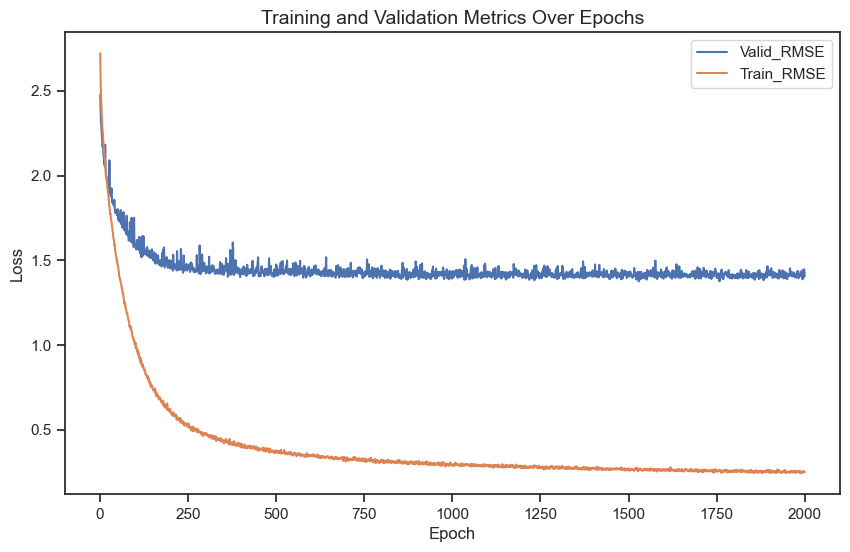

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [15]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.252484,0.252411,0.358300,0.358300,0.910050,0.953967,0.260481,NaN,1.397883,0.854809,0.854809,0.473109,0.692918,0.608722,0.473224,0.910051,1.394013
1996,1997,0.257482,0.256441,0.362109,0.362109,0.908614,0.953217,0.263657,NaN,1.402969,0.861599,0.861599,0.471192,0.691605,0.614766,0.473515,0.908615,1.399345
1997,1998,0.253725,0.253234,0.358696,0.358696,0.909757,0.953812,0.259602,NaN,1.447839,0.864686,0.864686,0.454279,0.695051,0.599744,0.459414,0.909757,1.444142
1998,1999,0.255526,0.254730,0.363190,0.363190,0.909224,0.953532,0.263919,NaN,1.426335,0.857069,0.857069,0.462385,0.693286,0.594084,0.465608,0.909224,1.422437
1999,2000,0.251024,0.251089,0.360680,0.360680,0.910521,0.954213,0.262890,NaN,1.406605,0.857396,0.857396,0.469821,0.692244,0.611319,0.469912,0.910521,1.403103


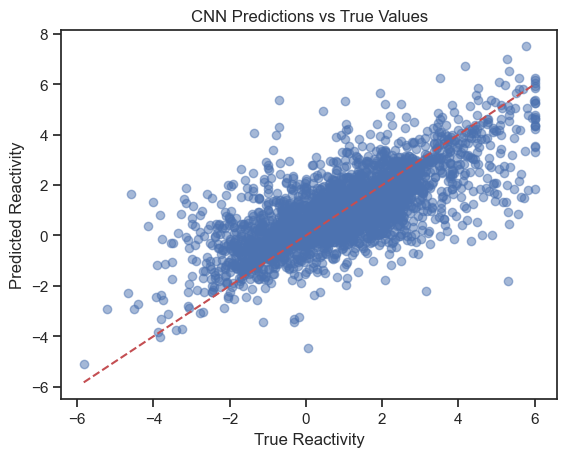

In [16]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
